# **Lab: Elasticity equations**
**Gustav Grevsten**

# **Abstract**

In this report, the FEniCS Python library was used in order to implement a finite element solution to the elasticity equations. A mesh with several cylinders was created, and the Young modulus, Poisson's ratio and velocities were then modified in order to observe the change in displacement and deformation of the materials.

# **About the code and report**

Most of the code as well as the introduction were provided courtesy of Prof. Johan Hoffman (jhoffman@kth.se) as a part of the course DD2365, Advanced Computation in Fluid Mechanics, at KTH Royal Institute of Technology, Stockholm, Sweden.

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)

# **Introduction**

The Elasticity equations take the form

$-\nabla \cdot \sigma = f$

together with suitable boundary conditions.

To derive the weak form of the equations, multiply the equation by $v\in V$, and then integrate over the domain $\Omega$ and use Green's formula
$
(-\nabla \cdot \sigma ,v) = (\nabla \sigma , \nabla v) 
- <\sigma \cdot n, v>_{\Gamma}
$

To model 

We seek a finite element approximation $u\in V$ such that 

$(\nabla \sigma,\nabla v) - <\sigma \cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $v \in V$. 



# **Method**

For this lab, a mesh with a uniform mesh size of $h = \frac{1}{32}$ was used with the dimensions $4 \times 2$. This mesh contained three cylinders, each with a radius of $r=0.2$, centered in the coordinates $(1.5,1), (2,1.5), (0.5,1)$.

**Define domain and mesh**

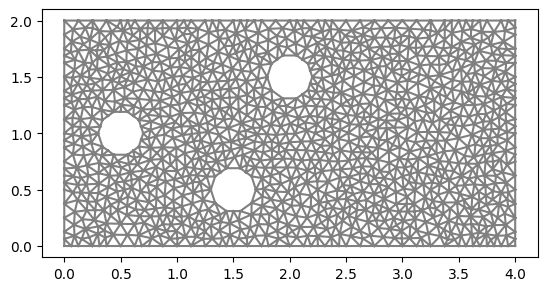

In [ ]:
L = 4
H = 2

def meshfunc():
  global L, H

  # Generate mesh (examples with and without a hole in the mesh) 
  resolution = 32
  mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(1.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

  # Local mesh refinement (specified by a cell marker)
  no_levels = 0
  for i in range(0,no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for cell in cells(mesh):
      cell_marker[cell] = False
      p = cell.midpoint()
      if p.distance(Point(1.5, 0.5)) < 1.0:
          cell_marker[cell] = True
    mesh = refine(mesh, cell_marker)
  
  return mesh

mesh = meshfunc()

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces and boundary conditions**

In [17]:
def function_space(mesh, vx = 0.5, vy = 0.0):
  global L, H
  # Generate finite element space
  VE = VectorElement("CG", mesh.ufl_cell(), 1)

  V = FunctionSpace(mesh, VE)

  # Define trial and test functions
  u = TrialFunction(V)
  v = TestFunction(V) 

  d = Function(V)

  # Define subdomains (for boundary conditions)
  class Left(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[0], 0.0) 

  class Right(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[0], L)

  class Lower(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[1], 0.0)

  class Upper(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[1], H)
        
  left = Left()
  right = Right()
  lower = Lower()
  upper = Upper()

  # Define mesh functions (for boundary conditions)
  boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
  boundaries.set_all(0)
  left.mark(boundaries, 1)
  right.mark(boundaries, 2)
  lower.mark(boundaries, 3)
  upper.mark(boundaries, 4)

  # Define boundary conditions 
  class DirichletBoundaryLower(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[1], 0.0)

  class DirichletBoundaryUpper(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[1], H)

  class DirichletBoundaryLeft(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[0], 0.0) 

  class DirichletBoundaryRight(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[0], L)

  class DirichletBoundaryObjects(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

  dbc_lower = DirichletBoundaryLower()
  dbc_upper = DirichletBoundaryUpper()
  dbc_left = DirichletBoundaryLeft()
  dbc_right = DirichletBoundaryRight()
  dbc_objects = DirichletBoundaryObjects()

  bcu_left0 = DirichletBC(V.sub(0), 0.0, dbc_left)
  bcu_left1 = DirichletBC(V.sub(1), 0.0, dbc_left)
  bcu_right0 = DirichletBC(V.sub(0), 0.0, dbc_right)
  bcu_right1 = DirichletBC(V.sub(1), 0.0, dbc_right)
  bcu_upper0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
  bcu_upper1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
  bcu_lower0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
  bcu_lower1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
  bcu_obj0 = DirichletBC(V.sub(0), vx, dbc_objects)
  bcu_obj1 = DirichletBC(V.sub(1), vy, dbc_objects)

  #bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
  bcu = [bcu_left0, bcu_left1, bcu_right0, bcu_right1, bcu_upper0, bcu_upper1, bcu_lower0, bcu_lower1, bcu_obj0, bcu_obj1]

  return VE, V, u, v, d, bcu

# **Results**

**Define and solve variational problem and visualize solution**

In [51]:
def solve_var(mesh, E = 1.0e10, nu = 0.3, vx = 0.5, vy = 0.0):
  
  VE, V, u, v, d, bcu = function_space(mesh, vx, vy)

  f = Expression(("0.0","0.0"), element = V.ufl_element())

  dim = u.geometric_dimension()
  mu = E*0.5/(1+nu)
  lambda_ = nu*E/((1.0+nu)*(1.0-2.0*nu))

  def epsilon(u):
      return 0.5*(grad(u) + grad(u).T)

  def sigma(u):
      #return 2.0*mu*epsilon(u)
      return lambda_*div(u)*Identity(dim) + 2.0*mu*epsilon(u)

  # Define variational problem on residual form: r(u,v) = 0
  residual = ( inner(sigma(u), epsilon(v))*dx - inner(f, v)*dx )

  au = lhs(residual)
  Lu = rhs(residual)

  A = assemble(au)
  b = assemble(Lu)

  [bc.apply(A, b) for bc in bcu]
  [bc.apply(d.vector()) for bc in bcu]

  solve(A, d.vector(), b, "bicgstab", "default")

  u1 = project(d, V)

  # Plot solution
  plt.figure()
  plot(u1, title="Displacement")

  plt.show()

  ALE.move(mesh, d)
  plt.figure()
  plot(mesh)
  plt.show()

We start by looking at the solution for various values of the Young modulus and Poissons ratio. We do this by first setting the variables $E = 10^{10}$ and $\nu = 0.3$:

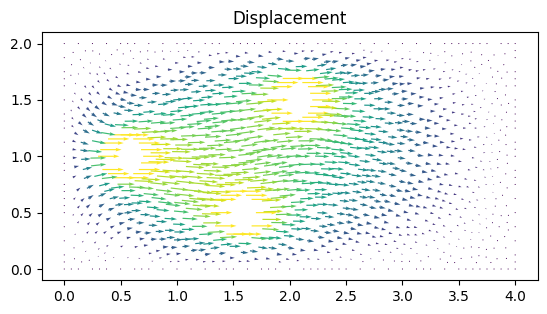

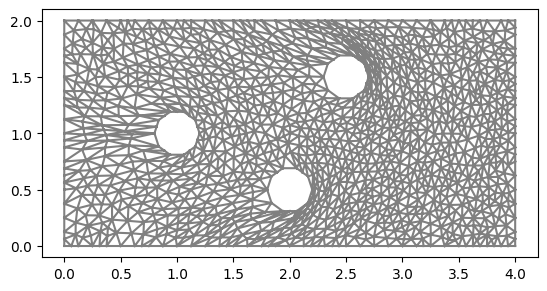

In [13]:
mesh = meshfunc()

solve_var(mesh, E = 1.0e10, nu = 0.3)

Modifying the elasticity modulus, we can look at both a relatively highly inelastic and elastic material. Starting with the rigid material with $E = 10^{13}$

DEBUG:UFL:Blocks of each mode: 



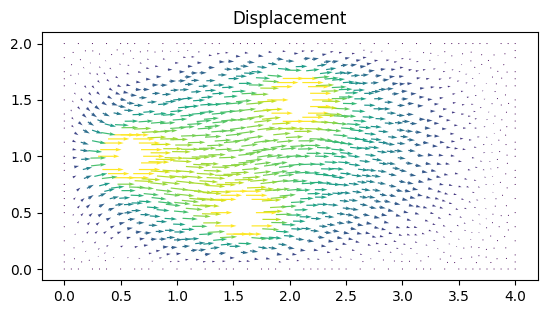

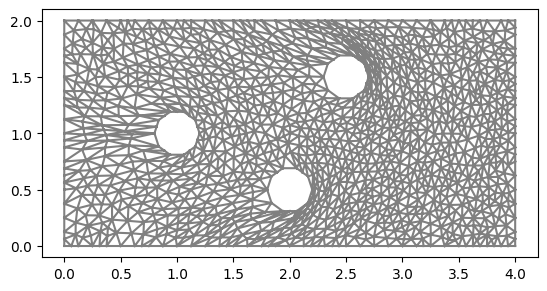

In [33]:
mesh = meshfunc()

solve_var(mesh, E = 10e13, nu = 0.3)

And an elastic material $E = 10^{6}$

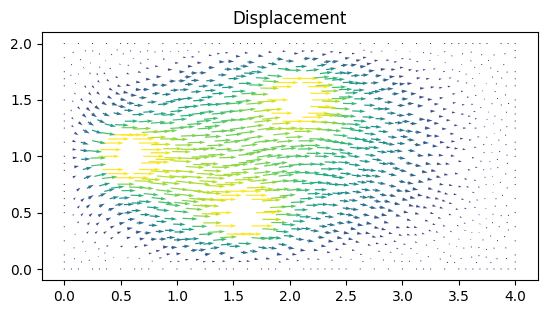

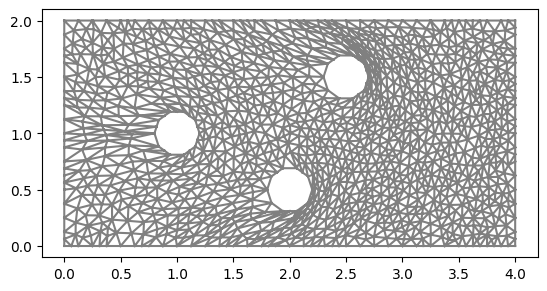

In [45]:
mesh = meshfunc()

solve_var(mesh, E = 1.0e6, nu = 0.3)

The Young modulus seemingly makes little to no difference in the results. This is to be expected, since it only influences the deformation of the material when stress is applied, not when displaced.

Next, we modify Poisson's ratio by changing $\nu$. We start with a very low value of $\nu = 0.1$:

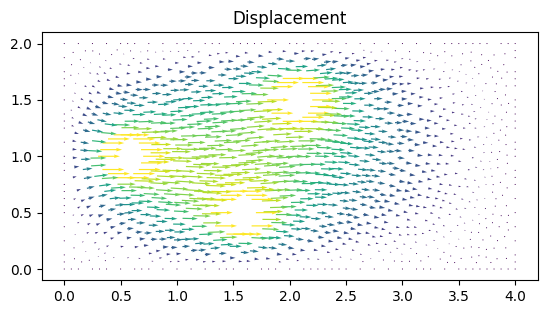

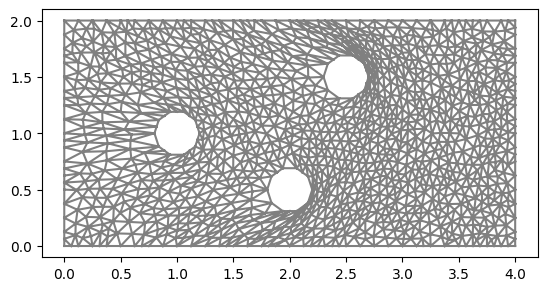

In [46]:
mesh = meshfunc()

solve_var(mesh, E = 1.0e10, nu = 0.05)

And a much higher value of $\nu = 0.492$ (the simulation breaks completely for values higher than this):

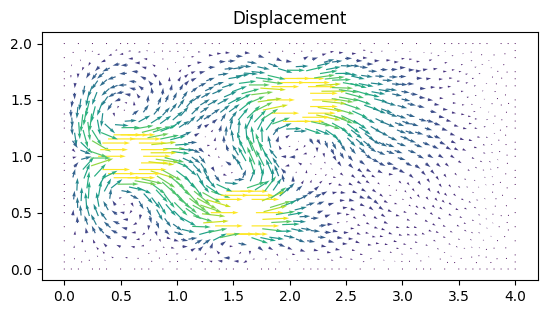

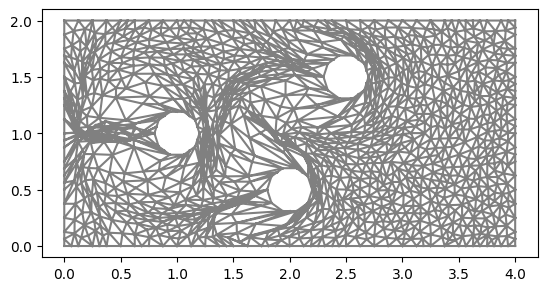

In [47]:
mesh = meshfunc()

solve_var(mesh, E = 1.0e10, nu = 0.492)

As we can see, Poisson's ratio has a much greater impact on the mesh deformation, with a higher value twisting the cells to a greater extent, specifically in the direction prependicular to the velocity.

Next, we look at how changing the velocity of the cylinders changes the deformation, starting with a movement of $(v_x, v_y) = (0, -0.25)$:

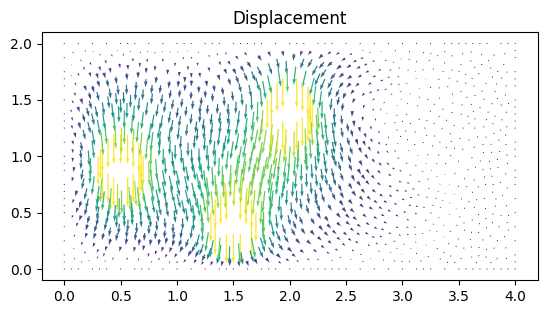

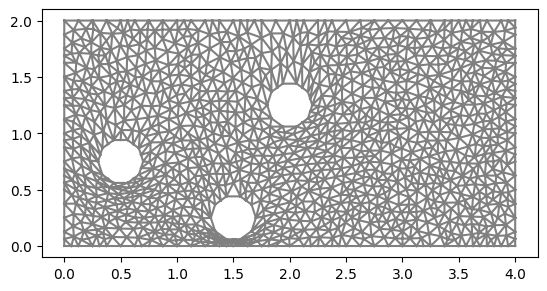

In [54]:
mesh = meshfunc()

solve_var(mesh, E = 1.0e10, nu = 0.3, vx = 0, vy = -0.25)

And a movement of $(v_x, v_y) = (1.5, 0)$:

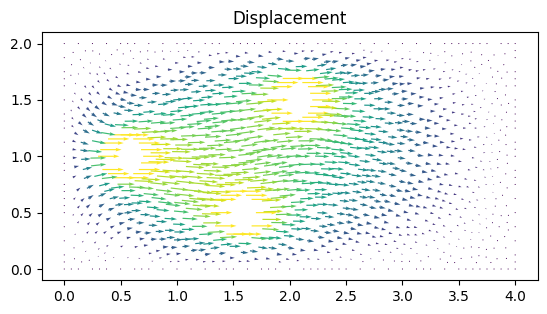

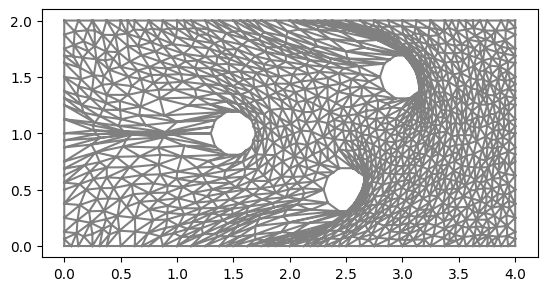

In [61]:
mesh = meshfunc()

solve_var(mesh, E = 1.0e10, nu = 0.3, vx = 1, vy = 0)

And finally a movement of $(v_x, v_y) = (1, 0.3)$:

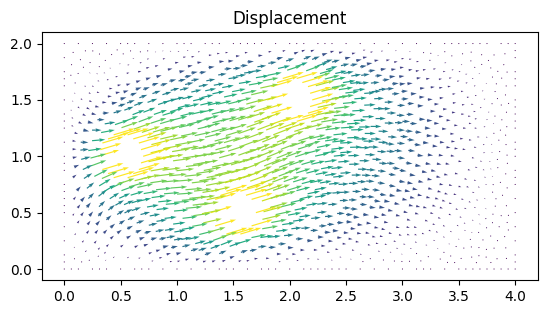

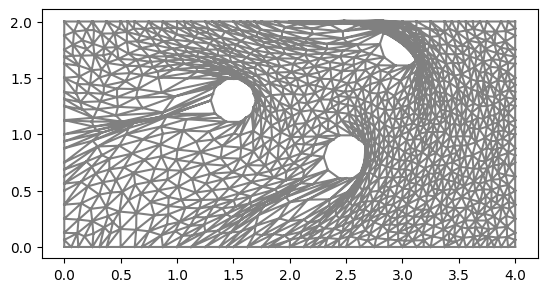

In [60]:
mesh = meshfunc()

solve_var(mesh, E = 1.0e10, nu = 0.3, vx = 1, vy = 0.3)

As we can see, the higher velocities cause strong deformations in the mesh. In fact, the simulation starts to break down as the velocity gets higher and the cylinders start to push against the walls, causing the mesh to start pushing up against the grid boundaries and deforming the triangles. the circles also start to lose their shape.

# **Discussion**

Through our results, we observed that the Young modulus has little impact on the displacement field as the cylinders move. We also observed that Poisson's ratio had a much higher impact on this, yielding expected results, as discussed.

We also noted that higher velocities tended to deform the grid further in the direction perpendicular to the velocity, ultimately causing the cylinders to deform. When the cylinders neared the boundaries of the grid, the mesh tended to get deformed and "pushed out" near the edge of the grid, potentially causing issues for the accuracy of simulations.